# Loading and Preparing Dataset

In [5]:
#Import packages
import numpy as np
import pandas as pd

np.random.seed(42)

#Sci-kit learn pipeline packages
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

#Sci-kit learn decision tree packages
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

#Sci-kit learn mean square error
from sklearn.metrics import mean_squared_error

#Grid Search packages, if needed
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
#Import dataset

path = r'C:\Users\Sandra\Documents\MZ fall 2017\sabermiketrics\Predictive_StatCast_Metrics_ML.xlsx'
df = pd.read_excel(path)

In [3]:
df.head(5)

,playerid,Season,PA,BB%,K%,wOBA,EV,Barrel%,maxEV,HardHit%,O-Swing%,xwoba,xba,Age,whiff_rate,wOBA_ny
0,10030,2017,386,0.044,0.225,0.313,86.6,0.021,108.4,0.288,0.404,0.273,0.237,25,0.229167,0.250
1,10047,2017,649,0.108,0.277,0.335,89.4,0.084,112.5,0.452,0.290,0.326,0.232,26,0.258475,0.328
2,10047,2018,343,0.087,0.274,0.328,90.5,0.073,112.9,0.457,0.338,0.340,0.274,27,0.248869,0.316
3,10047,2019,490,0.104,0.343,0.316,90.2,0.104,111.5,0.413,0.287,0.316,0.228,28,0.321192,0.400
4,10047,2020,218,0.083,0.257,0.400,91.0,0.148,109.2,0.458,0.258,0.393,0.282,29,0.259053,0.330


In [6]:
#Split into training and test set
train, test = train_test_split(df, test_size=0.3)

In [8]:
print(train.shape)
print(test.shape)

(656, 16)
(282, 16)


In [61]:
#Separate targets and inputs
train_y = train['wOBA_ny']
test_y = test['wOBA_ny']

train_inputs = train.drop(['playerid', 'Season', 'wOBA', 'wOBA_ny'], axis=1)
test_inputs = test.drop(['playerid', 'Season', 'wOBA', 'wOBA_ny'], axis=1)
#playerid and Season are irrelevant to machine learning, they are just unique identifiers.
#wOBA is dropped because it will be used as a baseline value, not as a feature to predict next year wOBA.
#xwOBA is dropped because that is the target.

# Pipeline

In [62]:
numeric_columns = ['PA', 'BB%', 'K%', 'EV', 'Barrel%', 'maxEV', 'HardHit%', 'O-Swing%', 'xwoba', 'xba', 'Age', 'whiff_rate']

In [63]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns)],
        remainder='passthrough')

In [64]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

print(train_x.shape)

(656, 12)


In [65]:
#Transform the test data
test_x = preprocessor.transform(test_inputs)

print(test_x.shape)

(282, 12)


# Baseline

As a baseline, we will predict every current-year wOBA as the next-year wOBA. The baseline RMSE ends up being 0.044, which is pretty high in the context of baseball metrics. wOBA, like batting averaged, is measured by the thousandths.

In [59]:
baseline_pred = test['wOBA']

In [60]:
baseline_mse = mean_squared_error(test_y, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)

print('Baseline RMSE: {}' .format(baseline_rmse))

Baseline RMSE: 0.04440840441829365


# Decision Tree 

We will use a grid search to find the best regularization paramters for our decision tree regression model. The two parameters we will search for are the minimum samples required to form a leaf in the decision tree, and a maximum depth to the tree to avoid overfitting.

In [66]:
param_grid = [
    {'min_samples_leaf': np.arange(5, 30), 
     'max_depth': np.arange(5,30)}
  ]

tree_reg = DecisionTreeRegressor()

grid_search = RandomizedSearchCV(tree_reg, param_grid, cv=5, n_iter=10,
                           scoring='neg_mean_squared_error', verbose=1,
                           return_train_score=True)

grid_search.fit(train_x, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions=[{'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29]),
                                         'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29])}],
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [67]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.03658213405854334 {'min_samples_leaf': 29, 'max_depth': 7}
0.0382622398180389 {'min_samples_leaf': 15, 'max_depth': 8}
0.043029047241674195 {'min_samples_leaf': 6, 'max_depth': 16}
0.0395484413655056 {'min_samples_leaf': 12, 'max_depth': 29}
0.04241957312000097 {'min_samples_leaf': 6, 'max_depth': 11}
0.03831910012693641 {'min_samples_leaf': 15, 'max_depth': 10}
0.0379642297490455 {'min_samples_leaf': 18, 'max_depth': 21}
0.038705614886848774 {'min_samples_leaf': 14, 'max_depth': 7}
0.036951571751699726 {'min_samples_leaf': 24, 'max_depth': 28}
0.03949061032897335 {'min_samples_leaf': 10, 'max_depth': 6}


In [68]:
grid_search.best_params_

{'min_samples_leaf': 29, 'max_depth': 7}

In [69]:
grid_search.best_estimator_
#This will be the decision tree regression model that I'll use as a model

DecisionTreeRegressor(max_depth=7, min_samples_leaf=29)

In [70]:
#Calculating RMSE for the model on training data
train_pred = grid_search.best_estimator_.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 0.03128255683813001


In [71]:
#Calculating RMSE for the model on test data. 
#This is the data that the model was not trained on, so the lowness on the RMSE here will be more telling.
test_pred = grid_search.best_estimator_.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 0.036504270141023205


The RMSE is telling us the normalized difference between predicted and actual values. A RMSE of 0.037 means that next year's wOBA can be predicted by 37 points (wOBA, like batting average and other stats, is written in the thousandths). This isn't too particularly accurate but is more accurate than the baseline.

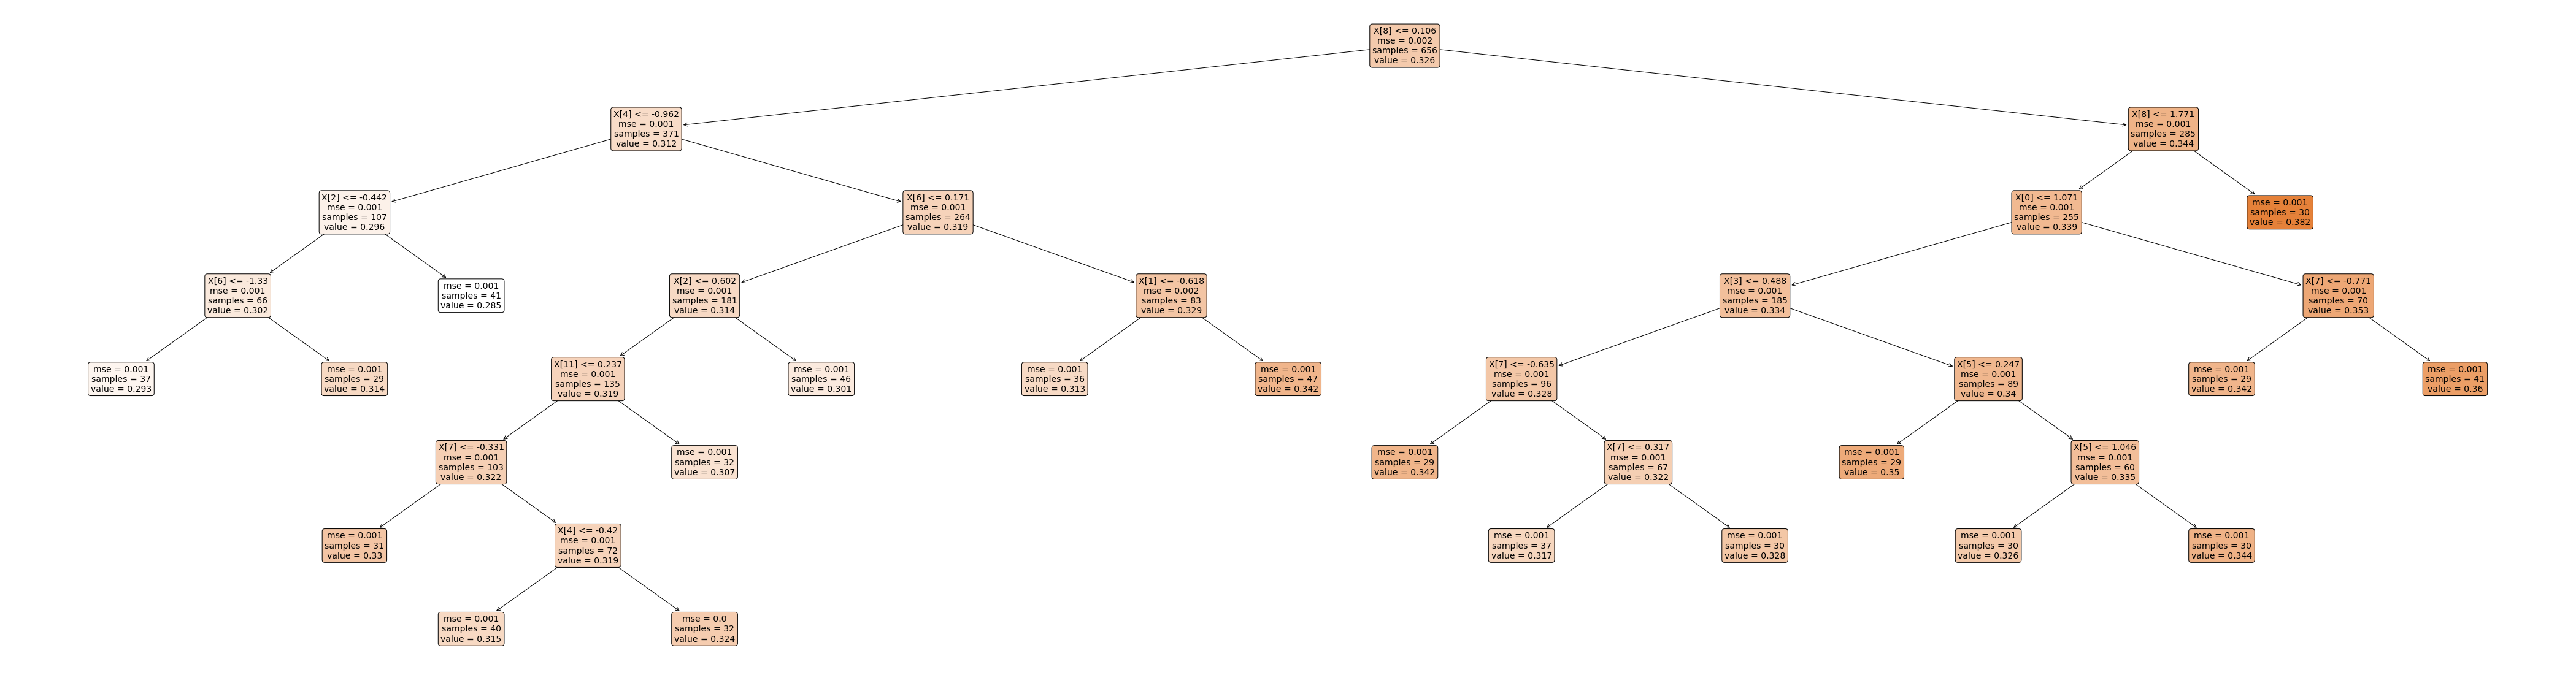

In [72]:
#Plot the tree
plt.figure(figsize=(75,20))

tree = plot_tree(grid_search.best_estimator_, 
              #feature_names=train_inputs.columns.values, # our feature names are stripped from the data set
              class_names=np.unique(train_y), 
              filled=True, 
              rounded=True, 
              fontsize=14)

For the context of understanding the decision tree, the "X[]" values correspond to these features:

X0 = PA

X1 = BB%

X2 = K%

X3 = EV

X4 = Barrel%

X5 = maxEV

X6 = HardHit%

X7 = O-Swing%

X8 = xwOBA

X9 = xBA

X10 = Age

X11 = whiff rate

Feature: 0, Score: 0.04834
Feature: 1, Score: 0.04559
Feature: 2, Score: 0.04856
Feature: 3, Score: 0.01845
Feature: 4, Score: 0.11845
Feature: 5, Score: 0.02602
Feature: 6, Score: 0.05744
Feature: 7, Score: 0.05085
Feature: 8, Score: 0.57202
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.01429


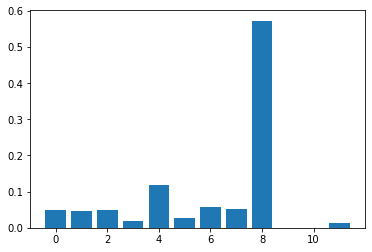

In [73]:
#Calculate feature importance, code copied from https://machinelearningmastery.com/calculate-feature-importance-with-python/


# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

# get importance
importance = grid_search.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

We can see here that most of the predictive value comes from xwOBA, which makes sense considering it is an all-encompassing stat that estimates wOBA based on batted-ball profile and plate discipline. Average exit velocity is the second most important feature. xBA and Age have no feature importance.



# Decision Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor

randomforest = RandomForestRegressor(n_estimators=500, n_jobs=-1)
randomforest.fit(train_x, train_y)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [75]:
#Calculating RMSE for the model on training data
train_pred = randomforest.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 0.012898368734305096


In [76]:
#Calculating RMSE for the model on test data. 
test_pred = randomforest.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 0.03592592396083524


The decision forest algorithm is just as accurate on the test data.

Feature: 0, Score: 0.08198
Feature: 1, Score: 0.06368
Feature: 2, Score: 0.06113
Feature: 3, Score: 0.05845
Feature: 4, Score: 0.09326
Feature: 5, Score: 0.06543
Feature: 6, Score: 0.10340
Feature: 7, Score: 0.05751
Feature: 8, Score: 0.24194
Feature: 9, Score: 0.06788
Feature: 10, Score: 0.04784
Feature: 11, Score: 0.05751


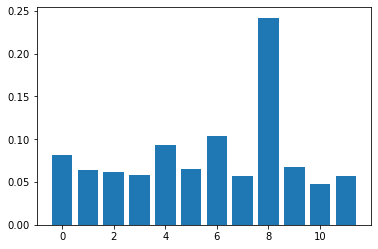

In [130]:
# get importance
importance = randomforest.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Support Vector Machines

In [77]:
from sklearn.svm import SVR 
svm = SVR(kernel="poly", degree=2, C=100, epsilon=0.5) 

svm.fit(train_x, train_y)

SVR(C=100, degree=2, epsilon=0.5, kernel='poly')

In [80]:
#Calculating RMSE for the model on training data
train_pred = svm.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 0.039216487946133936


In [81]:
#Calculating RMSE for the model on test data. 
test_pred = svm.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 0.03957265066748832


Support vector machines are even less accurate

# Neural Network

In [88]:
from sklearn.neural_network import MLPRegressor

deep_nn = MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=1000, early_stopping=True, alpha=0.1)
deep_nn.fit(train_x, train_y)

MLPRegressor(alpha=0.1, early_stopping=True, hidden_layer_sizes=(50, 50, 50),
             max_iter=1000)

In [89]:
#Calculating RMSE for the model on training data
train_pred = deep_nn.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 0.029737032011066


In [90]:
#Calculating RMSE for the model on test data. 
test_pred = deep_nn.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 0.035989413701942356


# Neural Network in Keras

In [91]:
import tensorflow as tf
from tensorflow import keras

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [93]:
neurons = train_x.shape[1]
neurons

#This is how many neurons should be in the input layer. It is equal to the number of features.

12

In [94]:
#Create our model by adding layers in Keras syntax
keras_nn = keras.models.Sequential()

keras_nn.add(keras.layers.Input(shape=neurons))
keras_nn.add(keras.layers.Dense(100, activation='relu'))
keras_nn.add(keras.layers.Dense(100, activation='relu'))
keras_nn.add(keras.layers.Dense(100, activation='relu'))

#Final layer: Because it's a regression task, the final layer has 1 neuron, no activation
keras_nn.add(keras.layers.Dense(1, activation=None))

In [119]:
# Compile model

#Optimizer:
#adam = keras.optimizers.Adam(lr=0.01)
rmsprop = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
keras_nn.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['mse'])

In [123]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

callback = [earlystop]

In [127]:
#Fit model

history = keras_nn.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=200, batch_size=100, callbacks=callback)

Epoch 1/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 9.9014e-04 - mse: 9.9014e

In [128]:
#Evaluate the model

train_scores = keras_nn.evaluate(train_x, train_y, verbose=0)
test_scores = keras_nn.evaluate(test_x, test_y, verbose=0)

In [129]:
#Print RMSE Metrics

print('Train RMSE: {}' .format(np.sqrt(train_scores[1])))
print('Test RMSE: {}' .format(np.sqrt(test_scores[1])))

Train RMSE: 0.036032907485576186
Test RMSE: 0.042056832345475845


No matter which algorithm I try, the best RMSE I can acheive is 0.036, accomplished from the decision forest, SVM, and original deep neural network.